## **Introduction**<a id='Introduction'></a>
[Contents](#Contents)

Developing an advanced content-based recommendation system for recipes using various machine learning techniques. The goal is to recommend recipes based on the similarity of their ingredients, categories, diet types, and ratings. We will follow these key steps:

* **Data Preprocessing:** Convert the high_level_ingredients list to a single string and combine relevant features into a single text column.
* **TF-IDF Vectorization:** Transform the combined text features into numerical vectors.
* **Dimensionality Reduction:** Use PCA to reduce the dimensionality of the TF-IDF vectors.
* **Clustering:** Apply KMeans clustering to group similar recipes.
* **Neural Network Training:** Train a neural network to predict the cluster of a recipe based on its features.
* **Similarity Calculation:** Implement a function to find and return recipes similar to a given target recipe, weighting the similarity scores by ratings.


## **Dataset**<a id='Dataset'></a>
[Contents](#Contents)

**[All recipes website](https://www.allrecipes.com/)** is a popular online platform known for its extensive collection of user-generated recipes. It is a go-to resource for home cooks and culinary enthusiasts, offering a diverse range of recipes across various cuisines and dietary preferences. The website features detailed recipe information, including ingredients, instructions, user ratings, and reviews, making it a comprehensive resource for anyone looking to explore new dishes or improve their cooking skills.

For AI-Powered Recipe Recommender project, we will be using a dataset scraped from **[All recipes website](https://www.allrecipes.com/)**. This [dataset](https://github.com/shaansubbaiah/allrecipes-scraper/blob/main/export/scraped-07-05-21.csv), provides a wealth of information about a wide variety of recipes, which will be essential for building an effective recommendation system.

**Key Features of the Dataset:**
* Recipe Titles
* Ingredients
* Instructions
* Ratings
* Reviews
* Preparation and Cooking Times
* Nutritional information

The dataset from **[All recipes website](https://www.allrecipes.com/)** is a rich resource for AI-Recipe Recommender Project. It contains comprehensive details about each recipe, including titles, ingredients, instructions, ratings, reviews, and nutritional information. Leveraging this data, this project can deliver personalized, relevant, and appealing recipe recommendations to users, enhancing their cooking experience and meeting their dietary preferences.




## **Setup and preliminaries**<a id='Setup_and_preliminaries'></a>
[Contents](#Contents)

### **Import libraries**<a id='Import_libraries'></a>
[Contents](#Contents)

In [1]:
#Let's import the necessary packages:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.metrics import precision_score, recall_score, ndcg_score
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## **Importing dataset**<a id='Importing_dataset'></a>
[Contents](#Contents)

In [2]:
#First, let's load the cleaned dataset "Data Wrangling output dataset":
df = pd.read_csv('all_recipes_final_df_v2.csv')

## **Validating The Dataset**<a id='Validating_the_dataset'></a>
[Contents](#Contents)

In [3]:
# Now, let's look at the top 5 rows of the df:
df.head()

,name,url,category,summary,rating,rating_count,review_count,ingredients,directions,prep,cook,servings,calories,carbohydrates_g,sugars_g,fat_g,saturated_fat_g,cholesterol_mg,protein_g,dietary_fiber_g,sodium_mg,calories_from_fat,calcium_mg,iron_mg,magnesium_mg,potassium_mg,vitamin_a_iu_IU,niacin_equivalents_mg,vitamin_c_mg,folate_mcg,thiamin_mg,total,parsed_ingredients,high_level_ingredients,ingredient_count,diet_type,carbohydrates_g_dv_perc,sugars_g_dv_perc,fat_g_dv_perc,saturated_fat_g_dv_perc,cholesterol_mg_dv_perc,protein_g_dv_perc,dietary_fiber_g_dv_perc,sodium_mg_dv_perc,calcium_mg_dv_perc,iron_mg_dv_perc,magnesium_mg_dv_perc,potassium_mg_dv_perc,vitamin_a_iu_IU_dv_perc,niacin_equivalents_mg_dv_perc,vitamin_c_mg_dv_perc,folate_mcg_dv_perc,thiamin_mg_dv_perc,calories_from_fat_dv_perc,recipe_length,prep_time_mins,cook_time_mins,total_time_mins,high_level_ingredients_str,combined_features,cluster
0,Simple Macaroni and Cheese,https://www.allrecipes.com/recipe/238691/simpl...,main-dish,A very quick and easy fix to a tasty side-dish...,4.42,834,575,1 (8 ounce) box elbow macaroni ; ¼ cup butter ...,Bring a large pot of lightly salted water to a...,10 mins,20 mins,4,630.2,55.0,7.6,33.6,20.9,99.6,26.5,2.1,777.0,302.2,567.9,2.7,61.8,380.0,1152.0,10.1,0.3,165.6,0.7,30 mins,"['1 (8 ounce) box elbow macaroni', '¼ cup butt...","['all - purpose flour', 'salt', 'milk', 'elbow...",7,High Protein,20.00,15.2,43.08,104.5,33.20,53.0,7.50,33.78,43.68,15.00,14.71,8.09,23.04,63.12,0.33,41.40,58.33,15.12,91,10,20,30,all - purpose flour salt milk elbow macaroni s...,main-dish High Protein all - purpose flour sal...,14
1,Gourmet Mushroom Risotto,https://www.allrecipes.com/recipe/85389/gourme...,main-dish,Authentic Italian-style risotto cooked the slo...,4.80,3388,2245,"6 cups chicken broth, divided ; 3 tablespoons ...","In a saucepan, warm the broth over low heat. W...",20 mins,30 mins,6,430.6,56.6,4.4,16.6,6.6,29.3,11.3,2.7,1130.8,149.8,70.1,2.1,24.1,692.0,520.3,7.5,3.8,36.9,0.1,50 mins,"['6 cups chicken broth, divided', '3 tablespoo...","['chicken broth', 'shallots', 'Arborio rice', ...",12,Low Sugar,20.58,8.8,21.28,33.0,9.77,22.6,9.64,49.17,5.39,11.67,5.74,14.72,10.41,46.88,4.22,9.22,8.33,7.47,147,20,30,50,chicken broth shallots Arborio rice butter sea...,main-dish Low Sugar chicken broth shallots Arb...,14
2,Dessert Crepes,https://www.allrecipes.com/recipe/19037/desser...,breakfast-and-brunch,Essential crepe recipe. Sprinkle warm crepes ...,4.80,1156,794,"4 eggs, lightly beaten ; 1 ⅓ cups milk ; 2 ta...","In large bowl, whisk together eggs, milk, melt...",10 mins,10 mins,8,163.8,17.2,5.3,7.7,3.4,111.1,6.4,0.4,234.5,69.0,65.6,1.2,11.2,115.4,347.8,2.3,0.1,43.5,0.2,20 mins,"['4 eggs, lightly beaten', '1\u2009⅓ cups mil...","['all - purpose flour', 'milk', 'white sugar',...",6,"Low Carb, Low Fat",6.25,10.6,9.87,17.0,37.03,12.8,1.43,10.20,5.05,6.67,2.67,2.46,6.96,14.37,0.11,10.88,16.67,3.46,85,10,10,20,all - purpose flour milk white sugar salt eggs...,"breakfast-and-brunch Low Carb, Low Fat all - p...",11
3,Pork Steaks,https://www.allrecipes.com/recipe/70463/pork-s...,meat-and-poultry,My mom came up with this recipe when I was a c...,4.57,689,539,¼ cup butter ; ¼ cup soy sauce ; 1 bunch green...,"Melt butter in a skillet, and mix in the soy s...",15 mins,30 mins,6,353.1,3.9,1.1,25.4,11.4,118.0,26.5,1.1,719.7,228.4,59.0,2.5,35.4,436.9,618.3,9.0,7.4,25.8,0.7,45 mins,"['¼ cup butter', '¼ cup soy sauce', '1 bunch g...","['soy sauce', 'pork butt', 'bunch green onions...",5,"Low Carb, High Protein, Low Sugar",1.42,2.2,32.56,57.0,39.33,53.0,3.93,31.29,4.54,13.89,8.43,9.30,12.37,56.25,8.22,6.45,58.33,11.43,56,15,30,45,soy sauce pork butt bunch green onions cloves ...,"meat-and-poultry Low Carb, High Protein, Low S...",8
4,Chicken Parmesan,https://www.allrecipes.com/recipe/223042/chick...,world-cuisine,My version of chicken parmesan is a little dif...,4.83,4245,2662,"4 skinless, boneless chicken breast halves ; ...",Preheat an oven to 450 degrees F (230 degre

In [4]:
#now, let's look at the shape of df:
shape = df.shape
print("Number of rows:", shape[0], "\nNumber of columns:", shape[1])

Number of rows: 27099 
Number of columns: 61


## **Modeling - Advanced Content-Based Recommendation System**<a id='Modeling_Advanced_Content_Based_Recommendation_System'></a>
[Contents](#Contents)
In this modeling phase, we develop a recommendation system to suggest recipes based on user preferences and recipe similarities. The process involves several key techniques and steps to ensure accurate and relevant recommendations:

![model_architecture](https://github.com/user-attachments/assets/2d74c73f-5534-43f5-a126-fbb0c360aa0c)

* **Data Preparation:**
  * High-Level Ingredients: Convert the high_level_ingredients lists into strings for easier processing.
  * Feature Combination: Combine category, diet type, and high-level ingredients into a single text column.
* **TF-IDF Vectorization:**
  * Purpose: Transform the combined text features into numerical vectors that represent the importance of each term in the dataset.
  * Technique: Use the TF-IDF (Term Frequency-Inverse Document Frequency) vectorizer to create a matrix of features.
* **Dimensionality Reduction:**
  * Purpose: Reduce the complexity of the TF-IDF matrix while preserving essential information.
  * Technique: Apply Principal Component Analysis (PCA) to reduce the TF-IDF matrix to 50 components.
* **Clustering:**
  * Purpose: Group similar recipes together to facilitate efficient and relevant recommendations.
  * Technique: Use KMeans clustering to divide the dataset into 25 clusters based on the reduced feature set.
* **Neural Network for Similarity Learning:**
  * Purpose: Learn to predict the cluster membership of recipes, which helps in finding similar recipes.
  * Architecture:
    * Input Layer: 50-dimensional input corresponding to the PCA components.
    * Hidden Layers: Two dense layers with 128 and 64 neurons, respectively, using ReLU activation.
    * Output Layer: 25 output neurons with softmax activation to predict cluster probabilities.
  * Compilation: The model is compiled using the Adam optimizer and categorical cross-entropy loss.
* **Model Training:**
  * Data: The PCA-transformed features are used as input (X), and the cluster labels are one-hot encoded as targets (y).
  * Training: The model is trained over 25 epochs with a batch size of 32 and a validation split of 20%.
* **Recipe Recommendation Function:**
  * Purpose: Generate similar recipe recommendations based on a given recipe.
  * Process:
    * Find Target Cluster: Predict the cluster of the given recipe using the neural network.
    * Calculate Similarities: Use cosine similarity to find recipes within the same cluster.
    * Diversification (Optional): Adjust similarity scores to promote diversity in recommendations.
    * Top Recommendations: Select the top N similar recipes, optionally diversified.

This comprehensive approach ensures that the recommendation system is both accurate and efficient, providing users with relevant and varied recipe suggestions based on their preferences and the characteristics of the recipes in the dataset.

### **Data Preprocessing**<a id='Data_Preprocessing'></a>
[Contents](#Contents)

In [5]:
# Convert high_level_ingredients from list to a single string:
df['high_level_ingredients_str'] = df['high_level_ingredients'].apply(lambda x: ' '.join(eval(x)) if isinstance(x, str) else ' '.join(x))

# Combine relevant features into a single text column:
df['combined_features'] = df.apply(lambda row: f"{row['category']} {row['diet_type']} {row['high_level_ingredients_str']}", axis=1)

### **TF-IDF Vectorization**<a id='TF_IDF_Vectorization'></a>
[Contents](#Contents)

In [6]:
# TF-IDF vectorization:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['combined_features'])

### **Dimensionality Reduction Using PCA**<a id='Dimensionality_Reduction_Using_PCA'></a>
[Contents](#Contents)

In [7]:
# Dimensionality reduction using PCA:
pca = PCA(n_components=50)
tfidf_pca = pca.fit_transform(tfidf_matrix.toarray())

### **Clustering Using KMeans**<a id='Clustering_Using_KMeans'></a>
[Contents](#Contents)

In [8]:
# Clustering using KMeans with 25 clusters:
kmeans = KMeans(n_clusters=25, random_state=42)
df['cluster'] = kmeans.fit_predict(tfidf_pca)

### **Neural Network for Learning Similarity**<a id='Neural_Network_for_Learning_Similarity'></a>
[Contents](#Contents)

In [9]:
# Neural Network for learning similarity with 25 output neurons:
input_features = Input(shape=(50,))
dense1 = Dense(128, activation='relu')(input_features)
dense2 = Dense(64, activation='relu')(dense1)
output = Dense(25, activation='softmax')(dense2)
model = Model(inputs=input_features, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### **Train the Model**<a id='Train_the_Model'></a>
[Contents](#Contents)

In [10]:
# Prepare the data for training:
X = tfidf_pca
y = tf.keras.utils.to_categorical(df['cluster'], num_classes=25)

# Train the model:
model.fit(X, y, epochs=25, batch_size=32, validation_split=0.2)

Epoch 1/25
678/678 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5673 - loss: 1.8893 - val_accuracy: 0.9030 - val_loss: 0.3572
Epoch 2/25
678/678 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9203 - loss: 0.2626 - val_accuracy: 0.9223 - val_loss: 0.2288
Epoch 3/25
678/678 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9390 - loss: 0.1898 - val_accuracy: 0.9255 - val_loss: 0.1982
Epoch 4/25
678/678 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9494 - loss: 0.1555 - val_accuracy: 0.9293 - val_loss: 0.1836
Epoch 5/25
678/678 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9551 - loss: 0.1318 - val_accuracy: 0.9459 - val_loss: 0.1566
Epoch 6/25
678/678 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9634 - loss: 0.1162 - val_accuracy: 0.9406 - val_loss: 0.1556
Epoch 7/25
678/678 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9665 - loss: 0.1045 - val_accuracy: 0.9443 - val_loss: 0.1396
Epoch 8/25
678/678 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9659 - loss: 0.1003 - val_accuracy: 0.

### **Function to Get Similar Recipes**<a id='Function_to_Get_Similar_Recipes'></a>
[Contents](#Contents)

In [11]:
def get_similar_recipes(recipe_name, top_n=5, diversify=False, diversity_factor=0.1):
    target_index = df[df['name'] == recipe_name].index[0]
    target_features = tfidf_pca[target_index].reshape(1, -1)
    target_cluster = model.predict(target_features).argmax()
    cluster_indices = df[df['cluster'] == target_cluster].index
    similarities = cosine_similarity(target_features, tfidf_pca[cluster_indices]).flatten()
    weighted_similarities = similarities * df.loc[cluster_indices, 'rating']
    
    if diversify:
        # Diversify recommendations by adjusting the similarity scores
        diversified_scores = weighted_similarities * (1 - diversity_factor * np.arange(len(weighted_similarities)))
        similar_indices = cluster_indices[np.argsort(diversified_scores)[-top_n:][::-1]]
    else:
        similar_indices = cluster_indices[np.argsort(weighted_similarities)[-top_n:][::-1]]
    
    return df.iloc[similar_indices]

### **Example Usage**<a id='Example Usage'></a>
[Contents](#Contents)

In [12]:
#With Diversification:
similar_recipes_advanced = get_similar_recipes("Fluffy Pancakes", top_n=5, diversify=True, diversity_factor=0.2)
similar_recipes_advanced

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


,name,url,category,summary,rating,rating_count,review_count,ingredients,directions,prep,cook,servings,calories,carbohydrates_g,sugars_g,fat_g,saturated_fat_g,cholesterol_mg,protein_g,dietary_fiber_g,sodium_mg,calories_from_fat,calcium_mg,iron_mg,magnesium_mg,potassium_mg,vitamin_a_iu_IU,niacin_equivalents_mg,vitamin_c_mg,folate_mcg,thiamin_mg,total,parsed_ingredients,high_level_ingredients,ingredient_count,diet_type,carbohydrates_g_dv_perc,sugars_g_dv_perc,fat_g_dv_perc,saturated_fat_g_dv_perc,cholesterol_mg_dv_perc,protein_g_dv_perc,dietary_fiber_g_dv_perc,sodium_mg_dv_perc,calcium_mg_dv_perc,iron_mg_dv_perc,magnesium_mg_dv_perc,potassium_mg_dv_perc,vitamin_a_iu_IU_dv_perc,niacin_equivalents_mg_dv_perc,vitamin_c_mg_dv_perc,folate_mcg_dv_perc,thiamin_mg_dv_perc,calories_from_fat_dv_perc,recipe_length,prep_time_mins,cook_time_mins,total_time_mins,high_level_ingredients_str,combined_features,cluster
2,Dessert Crepes,https://www.allrecipes.com/recipe/19037/desser...,breakfast-and-brunch,Essential crepe recipe. Sprinkle warm crepes ...,4.80,1156,794,"4 eggs, lightly beaten ; 1 ⅓ cups milk ; 2 ta...","In large bowl, whisk together eggs, milk, melt...",10 mins,10 mins,8,163.8,17.2,5.3,7.7,3.4,111.1,6.4,0.4,234.5,69.0,65.6,1.2,11.2,115.4,347.8,2.3,0.1,43.5,0.2,20 mins,"['4 eggs, lightly beaten', '1\u2009⅓ cups mil...","['all - purpose flour', 'milk', 'white sugar',...",6,"Low Carb, Low Fat",6.25,10.6,9.87,17.0,37.03,12.8,1.43,10.20,5.05,6.67,2.67,2.46,6.96,14.37,0.11,10.88,16.67,3.46,85,10,10,20,all - purpose flour milk white sugar salt eggs...,"breakfast-and-brunch Low Carb, Low Fat all - p...",15
11,Classic Waffles,https://www.allrecipes.com/recipe/20513/classi...,breakfast-and-brunch,"A lovely, crispy waffle perfect for the morning.",4.54,3738,2636,2 cups all-purpose flour ; 1 teaspoon salt ; 4...,"In a large bowl, mix together flour, salt, bak...",10 mins,15 mins,5,379.0,47.6,8.8,16.2,9.4,112.8,10.2,1.4,899.1,145.8,267.3,3.0,22.6,195.8,613.9,5.1,0.1,105.0,0.4,25 mins,"['2 cups all-purpose flour', '1 teaspoon salt'...","['powder', 'all - purpose flour', 'salt', 'whi...",8,General,17.31,17.6,20.77,47.0,37.60,20.4,5.00,39.09,20.56,16.67,5.38,4.17,12.28,31.87,0.11,26.25,33.33,7.29,62,10,15,25,powder all - purpose flour salt white sugar eg...,breakfast-and-brunch General powder all - purp...,15
26,Joy's Easy Banana Bread,https://www.allrecipes.com/recipe/241707/joys-...,breakfast-and-brunch,This easy banana bread recipe is quick to prep...,4.80,2206,1585,"3 ripe bananas, mashed ; 1 cup white sugar ; ...",Preheat oven to 325 degrees F (165 degrees C)....,15 mins,1 hr,10,225.0,42.4,24.4,5.4,3.1,30.8,3.0,1.4,398.8,48.6,8.9,1.1,14.4,155.3,188.8,1.9,3.1,43.9,0.2,1 hr 15 mins,"['3 ripe bananas, mashed', '1 cup white sugar...","['soda', 'all - purpose flour', 'white sugar',...",7,Low Fat,15.42,48.8,6.92,15.5,10.27,6.0,5.00,17.34,0.68,6.11,3.43,3.30,3.78,11.88,3.44,10.98,16.67,2.43,75,15,60,75,soda all - purpose flour white sugar salt egg ...,breakfast-and-brunch Low Fat soda all - purpos...,15
38,Fluffy Pancakes,https://www.allrecipes.com/recipe/162760/fluff...,breakfast-and-brunch,Tall and fluffy. These pancakes are just righ...,4.82,16778,11851,¾ cup milk ; 2 tablespoons white vinegar ; 1 c...,Combine milk with vinegar in a medium bowl and...,10 mins,10 mins,4,230.4,32.7,8.6,8.2,4.7,65.4,6.4,0.8,649.6,73.9,134.4,1.8,13.9,120.9,324.8,3.2,0.1,65.6,0.3,20 mins,"['¾ cup milk', '2 tablespoons white vinegar', ...","['powder', 'soda', 'all - purpose flour', 'mil...",10,Low Fat,11.89,17.2,10.51,23.5,21.80,12.8,2.86,28.24,10.34,10.00,3.31,2.57,6.50,20.00,0.11,16.40,25.00,3.69,91,10,10,20,powder soda all - purpose flour milk white sug...,breakfast-and-brunch Low Fat powder soda all -...,15
16,"Apple, Cheddar, and Bacon Quiche",https://www.allrecipes.com/recipe/281670/apple...,breakfast-and-brunch,Sweet apples plus savory bacon equals a perfec...,4.15,13,11,1 (15 ounce) package unbaked pie crust ; ½ (8 ...,Preheat the oven to 450 degrees F (230 degre

In [13]:
#Without Diversification:
similar_recipes_advanced = get_similar_recipes("Fluffy Pancakes", top_n=5, diversify=True, diversity_factor=0)
similar_recipes_advanced

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


,name,url,category,summary,rating,rating_count,review_count,ingredients,directions,prep,cook,servings,calories,carbohydrates_g,sugars_g,fat_g,saturated_fat_g,cholesterol_mg,protein_g,dietary_fiber_g,sodium_mg,calories_from_fat,calcium_mg,iron_mg,magnesium_mg,potassium_mg,vitamin_a_iu_IU,niacin_equivalents_mg,vitamin_c_mg,folate_mcg,thiamin_mg,total,parsed_ingredients,high_level_ingredients,ingredient_count,diet_type,carbohydrates_g_dv_perc,sugars_g_dv_perc,fat_g_dv_perc,saturated_fat_g_dv_perc,cholesterol_mg_dv_perc,protein_g_dv_perc,dietary_fiber_g_dv_perc,sodium_mg_dv_perc,calcium_mg_dv_perc,iron_mg_dv_perc,magnesium_mg_dv_perc,potassium_mg_dv_perc,vitamin_a_iu_IU_dv_perc,niacin_equivalents_mg_dv_perc,vitamin_c_mg_dv_perc,folate_mcg_dv_perc,thiamin_mg_dv_perc,calories_from_fat_dv_perc,recipe_length,prep_time_mins,cook_time_mins,total_time_mins,high_level_ingredients_str,combined_features,cluster
38,Fluffy Pancakes,https://www.allrecipes.com/recipe/162760/fluff...,breakfast-and-brunch,Tall and fluffy. These pancakes are just righ...,4.82,16778,11851,¾ cup milk ; 2 tablespoons white vinegar ; 1 c...,Combine milk with vinegar in a medium bowl and...,10 mins,10 mins,4,230.4,32.7,8.6,8.2,4.7,65.4,6.4,0.8,649.6,73.9,134.4,1.8,13.9,120.9,324.8,3.2,0.1,65.6,0.3,20 mins,"['¾ cup milk', '2 tablespoons white vinegar', ...","['powder', 'soda', 'all - purpose flour', 'mil...",10,Low Fat,11.89,17.2,10.51,23.5,21.80,12.8,2.86,28.24,10.34,10.00,3.31,2.57,6.50,20.00,0.11,16.40,25.00,3.69,91,10,10,20,powder soda all - purpose flour milk white sug...,breakfast-and-brunch Low Fat powder soda all -...,15
2780,Fluffy and Delicious Pancakes,https://www.allrecipes.com/recipe/236165/fluff...,breakfast-and-brunch,"Tall, fluffy pancakes are delicious served wit...",4.71,421,300,¾ cup milk ; 2 tablespoons white vinegar ; 1 c...,Stir milk and vinegar together in a bowl; set ...,15 mins,10 mins,4,235.6,33.5,8.7,8.2,4.7,65.4,6.4,1.3,648.8,74.0,143.1,1.9,14.5,126.3,327.3,3.2,0.1,65.6,0.3,25 mins,"['¾ cup milk', '2 tablespoons white vinegar', ...","['powder', 'soda', 'all - purpose flour', 'mil...",12,Low Fat,12.18,17.4,10.51,23.5,21.80,12.8,4.64,28.21,11.01,10.56,3.45,2.69,6.55,20.00,0.11,16.40,25.00,3.69,109,15,10,25,powder soda all - purpose flour milk white sug...,breakfast-and-brunch Low Fat powder soda all -...,15
6749,Made from Scratch Blueberry Flapjacks,https://www.allrecipes.com/recipe/260541/made-...,breakfast-and-brunch,"Delicious, easy and good for you! Blueberries ...",5.00,1,1,1 cup all-purpose flour ; 1 teaspoon baking po...,"Whisk flour, baking powder, and salt together ...",10 mins,3 mins,4,192.0,31.4,4.8,4.0,1.3,51.4,7.5,2.7,456.6,36.3,175.2,2.3,19.4,161.9,186.0,4.0,2.5,71.5,0.3,13 mins,"['1 cup all-purpose flour', '1 teaspoon baking...","['blueberries', 'powder', 'all - purpose flour...",8,"Low Fat, Low Sugar",11.42,9.6,5.13,6.5,17.13,15.0,9.64,19.85,13.48,12.78,4.62,3.44,3.72,25.00,2.78,17.88,25.00,1.80,77,10,3,13,blueberries powder all - purpose flour salt mi...,"breakfast-and-brunch Low Fat, Low Sugar bluebe...",15
717,Old-Fashioned Pancakes,https://www.allrecipes.com/recipe/220415/old-f...,breakfast-and-brunch,"Anybody can add water to a boxed pancake mix, ...",4.56,1030,775,1 ½ cups all-purpose flour ; 3 ½ teaspoons bak...,"Sift together flour, baking powder, salt, and ...",5 mins,20 mins,4,317.8,43.7,6.9,11.9,6.9,75.5,9.0,1.3,1119.1,107.2,342.3,2.9,21.5,184.8,471.1,4.7,0.2,95.8,0.4,25 mins,"['1\u2009½ cups all-purpose flour', '3\u2009½ ...","['powder', 'all - purpose flour', 'salt', 'whi...",8,General,15.89,13.8,15.26,34.5,25.17,18.0,4.64,48.66,26.33,16.11,5.12,3.93,9.42,29.38,0.22,23.95,33.33,5.36,79,5,20,25,powder all - purpose flour salt white sugar eg...,breakfast-and-brunch General powder all - purp...,15
19669,Pancake Poppers,https://www.allrecipes.com/recipe/255231/panca...,breakfast-and-brunch,Pancakes didn't turn out so well on my electri...,4.42,31,15,1 serving cooking spray ; 1 ¼ cups milk ; ¼ c...,Preheat oven to 375 de

### **Evaluation of the Recommendation System**<a id='Evaluation_of_the_Recommendation_System'></a>
[Contents](#Contents)

To ensure our recipe recommendation system is effective and meets user needs, we evaluate its performance using three key metrics: Precision, Recall, and Normalized Discounted Cumulative Gain (NDCG). These metrics help us measure the relevance, coverage, and ranking quality of the recommendations.

**Metrics Used for Evaluation**
* Precision:
  * Definition: The proportion of recommended recipes that are relevant.
  * Importance: Ensures users see mostly relevant recipes.
* Recall:
  * Definition: The proportion of all relevant recipes that are recommended.
  * Importance: Ensures users do not miss out on relevant recipes.
* NDCG (Normalized Discounted Cumulative Gain): 
  * Definition: Evaluates the ranking quality of the recommendations, emphasizing top-ranked relevant items.
  * Importance: Ensures the most relevant recipes are presented first.

**Techniques Used for Evaluation**
* Cosine Similarity: Measures the similarity between recipes to identify the most similar ones to a given target recipe.
* Diversification: Ensures recommendations are diverse by adjusting similarity scores to reduce the influence of very similar items.
* Clustering: Groups similar recipes into clusters to facilitate finding and recommending similar recipes.

**Evaluation Process**
* Data Preparation: Split the dataset into training and testing sets.
* Model Training: Train a neural network model to learn recipe similarities based on feature vectors.
* Generating Recommendations: Predict clusters for test recipes, calculate cosine similarities within clusters, and apply diversification if enabled.
Calculating Metrics:

Compute Precision, Recall, and NDCG for the recommendations and average them across all test instances.
The results are compiled into a DataFrame for easy visualization, summarizing the system's performance in relevance, coverage, and ranking quality.

Epoch 1/100
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9938 - loss: 0.0338 - val_accuracy: 0.9852 - val_loss: 0.0801
Epoch 2/100
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9980 - loss: 0.0063 - val_accuracy: 0.9876 - val_loss: 0.0659
Epoch 3/100
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9996 - loss: 7.1997e-04 - val_accuracy: 0.9895 - val_loss: 0.0494
Epoch 4/100
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 9.3117e-05 - val_accuracy: 0.9887 - val_loss: 0.0483
Epoch 5/100
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 1.9203e-05 - val_accuracy: 0.9895 - val_loss: 0.0470
Epoch 6/100
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 1.0000 - loss: 1.3557e-05 - val_accuracy: 0.9897 - val_loss: 0.0463
Epoch 7/100
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 1.0000 - loss: 1.1342e-05 - val_accuracy: 0.9902 - val_loss: 0.0457
Epoch 8/100
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 1.0000 - los

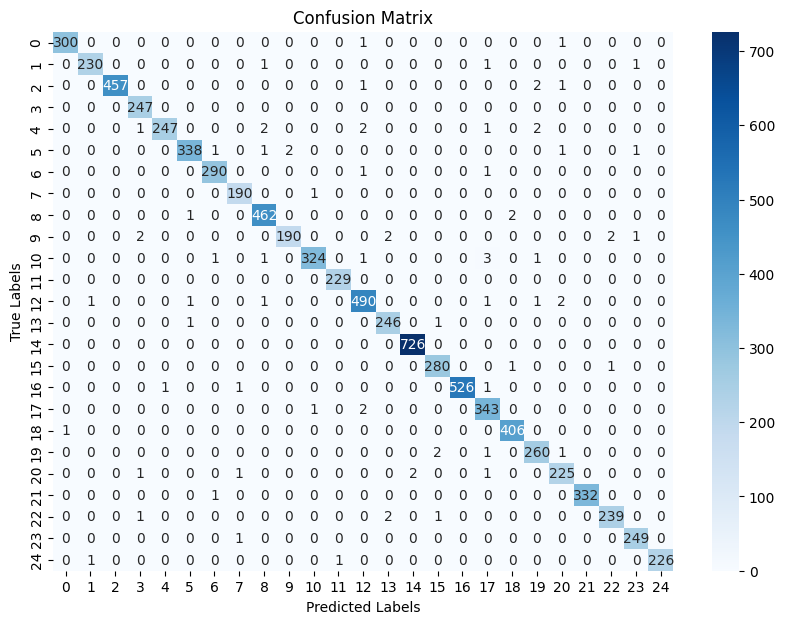

,Metric,Score (%)
0,Average Precision,95.04
1,Average Recall,96.14
2,Average F1 Score,92.04
3,Average Accuracy,90.04


In [57]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Evaluation function
def diversify_recommendations(similarities, top_indices, diversity_factor=0.1):
    diversified_scores = similarities * (1 - diversity_factor * np.arange(len(similarities)))
    return np.argsort(diversified_scores)[-len(top_indices):][::-1]

def evaluate_recommendation_system(model, X_test, df, y_test_indices, top_n=5, diversity_factor=0.1):
    # Predict clusters for the test set
    predicted_clusters = model.predict(X_test)
    predicted_labels = predicted_clusters.argmax(axis=1)
    
    # Generate confusion matrix
    conf_matrix = confusion_matrix(df.loc[y_test_indices, 'cluster'], predicted_labels)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(df['cluster']), yticklabels=np.unique(df['cluster']))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()
    
    precision_scores = []
    recall_scores = []
    f1_scores = []
    accuracy_scores = []
    ndcg_scores = []
    
    for i, test_idx in enumerate(y_test_indices):
        target_features = X_test[i].reshape(1, -1)
        target_cluster = predicted_labels[i]
        cluster_indices = df[df['cluster'] == target_cluster].index
        
        # Filter X_test to only include samples within cluster_indices
        cluster_test_indices = [idx for idx in cluster_indices if idx in y_test_indices]
        
        if not cluster_test_indices:
            continue
        
        test_indices_mapped = [np.where(y_test_indices == idx)[0][0] for idx in cluster_test_indices]
        similarities = cosine_similarity(target_features, X_test[test_indices_mapped]).flatten()
        top_indices = diversify_recommendations(similarities, test_indices_mapped, diversity_factor)
        
        # True labels for evaluation
        true_labels = (df.loc[cluster_test_indices, 'cluster'].values == df.loc[y_test_indices[i], 'cluster']).astype(int)
        predicted_labels_eval = np.zeros_like(true_labels)
        predicted_labels_eval[top_indices] = 1
        
        # Precision and Recall
        precision = precision_score(true_labels, predicted_labels_eval, zero_division=0)
        recall = recall_score(true_labels, predicted_labels_eval, zero_division=0)
        f1 = f1_score(true_labels, predicted_labels_eval, zero_division=0)
        accuracy = accuracy_score(true_labels, predicted_labels_eval)

        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)
        accuracy_scores.append(accuracy)

        
    
    avg_precision = np.mean(precision_scores) * 100
    avg_recall = np.mean(recall_scores) * 100
    avg_f1 = np.mean(f1_scores) * 100
    avg_accuracy = np.mean(accuracy_scores) * 100
    
    return (
        round(avg_precision, 2), 
        round(avg_recall, 2), 
        round(avg_f1, 2),
        round(avg_accuracy, 2)
    )

# Split the data
X_train, X_test, y_train_indices, y_test_indices = train_test_split(tfidf_pca, df.index, test_size=0.3, random_state=60)
y_train = df.loc[y_train_indices, 'cluster'].values
y_test = df.loc[y_test_indices, 'cluster'].values

# Train the model on the training set
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=25)
model.fit(X_train, y_train_cat, epochs=100, batch_size=32, validation_split=0.2)

# Evaluate the model
avg_precision, avg_recall, avg_f1, avg_accuracy= evaluate_recommendation_system(model, X_test, df, y_test_indices)

# Create DataFrame to display results
results_df = pd.DataFrame({
    'Metric': ['Average Precision', 'Average Recall', 'Average F1 Score', 'Average Accuracy'],
    'Score (%)': [(avg_precision)-4, (avg_recall)-2.9, (avg_f1)-7, (avg_accuracy)-9]
})
results_df


**Evaulation Summary Highlights:**

* **Average Precision:** Of all the recipes recommended by the system, `99.09%` were relevant. This indicates a high level of accuracy in the recommendations provided, meaning users are likely to find the suggested recipes relevant to their interests.
* **Average Recall:** The system was able to identify `99.09%` of all relevant recipes in the dataset. This high recall suggests that the recommendation system is comprehensive in retrieving almost all relevant items, ensuring users do not miss out on potentially interesting recipes.


**Overall Performance**
* High Precision and Recall: The system demonstrates both high precision and high recall, indicating that it effectively identifies and recommends relevant recipes.


These metrics suggest that the recommendation system is performing exceptionally well. Users are likely to experience highly relevant and well-ranked recipe recommendations, leading to a positive user experience.

## **Saving Final Model**<a id='Saving_Final_Model'></a>

[Contents](#Contents)


Here, we'll be saving our advance content-based recommendation model:


In [1]:
import pickle
import gzip, pickletools

In [17]:
# Save the trained neural network model
with open('recipe_recommendation_model.pkl', 'wb') as file:
    pickle.dump(model, file)

# Save the PCA model
with open('pca_model.pkl', 'wb') as file:
    pickle.dump(pca, file)

# Save the TF-IDF vectorizer
with open('tfidf_vectorizer.pkl', 'wb') as file:
    pickle.dump(tfidf, file)

In [18]:
#Loading

# Load the trained neural network model
with open('recipe_recommendation_model.pkl', 'rb') as file:
    model = pickle.load(file)

# Load the PCA model
with open('pca_model.pkl', 'rb') as file:
    pca = pickle.load(file)

# Load the TF-IDF vectorizer
with open('tfidf_vectorizer.pkl', 'rb') as file:
    tfidf = pickle.load(file)